## ¿Qué es _Machine Learning (ML)_?

**Primero** realizamos experimentos (ciencia), **después** desarrollamos productos (ingeniería)

Dos roles $\rightarrow$ dos flujos de trabajo:

- **diseñador** de algoritmos de ML $\rightarrow$ se enfoca en cómo se **genera un modelo**.
- **usuario** de algoritmos de ML $\rightarrow$ se enfoca que **calibrar modelos** respecto a unos datos concretos.


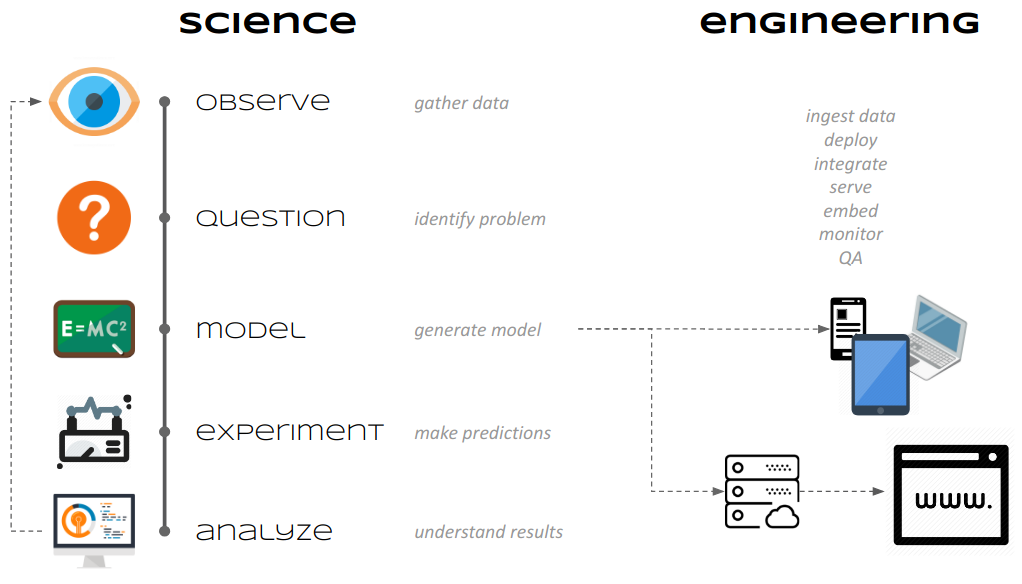

In [1]:
from IPython.display import Image
Image(filename='imgs/science_engineering.png', width=600)

Los modelos inducidos por los datos son generados por **algoritmos de ML**

`sklearn` ofrece herramientas para soportar la mayor parte del flujo de trabajo de un **usuario ML** (pero no _empaqueta_ un modelo para llevarlo a un entorno de producción)

`tensorflow` se originó como una herramienta para **diseñadores** de algoritmos ML, y va incluyendo gradualmente elementos para soportar a **usuarios ML**.

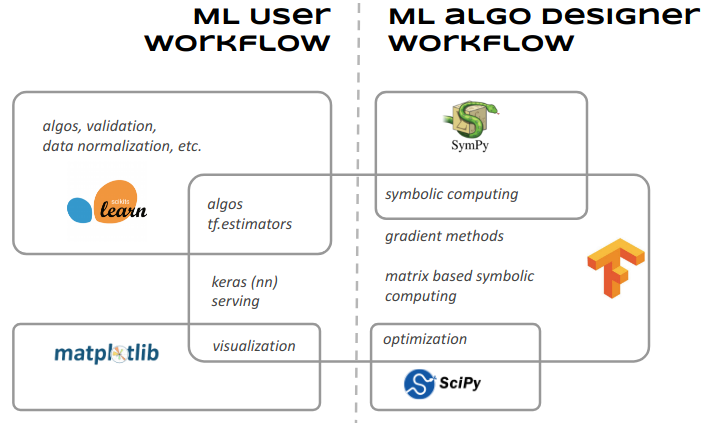

In [2]:
Image(filename='imgs/ml_workflows_tools.png', width=600)

we will first focus on understanding the **ML User Workflow**. As this is a TF course, we will use TF as much as possible, although we will resort to sklearn when:

- things are not available in TF
- things in sklearn are easier or more efficient to use

# ¿Qué es un modelo derivado de los datos?

- en 2D, un modelo de clasificación **es una frontera** en el plano

- **supongamos** que tenemos acceso a las distribuciones de las que surgen los datos $\rightarrow$ podemos muestrear tantas veces como queramos

- ¿cuál es la frontera que produce menos error de clasificación?

- $\epsilon$ es el error de clasificación calculado analíticamente **con la frontera óptima** porque conocemos las distribuciones que generan los datos.
- $\hat{\epsilon}$ es el error de clasificacón calculado con la muestra de datos y **con la frontera óptima** (conocida también como _frontera bayesiana_).

In [3]:
import mlutils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline
print "using TF version", tf.__version__

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


using TF version 1.9.0


/opt/miniconda/lib/python2.7/site-packages/scipy/stats/_multivariate.py:652: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


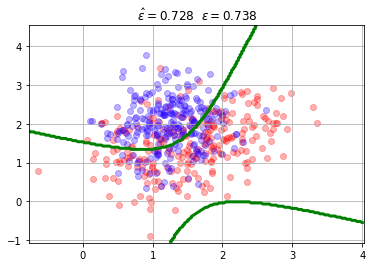

In [4]:
mc = mlutils.Example_Bayes2DClassifier(mean0=[1.5, 1.5], cov0=[[0.5, 0.1], [0.3, 0.5]],
                                        mean1=[1.2, 2.], cov1=[[0.2,0.1],[0,.5]])
X,y = mc.sample(500)
mlutils.plot_2Ddata_with_boundary(mc.predict, X, y, line_width=3, line_color="green", dots_alpha=.3)
plt.title(" $\hat{\epsilon}=%.3f$"%mc.score(X,y)+"  $\epsilon=%.3f$"%mc.analytic_score());
plt.grid();

haz los siguientes experimentos:

- separa los centros de las distribuciones de cada clase (`mean0`, `mean1`).
- aumenta y disminuye las matrices de covarianza.
- aumenta y disminuye el número de muestras.


- observa la estabilidad de $\hat{\epsilon}$ respecto a $\epsilon$ según ambas clases están más mezcladas o hay más o menos datos.

en general **SOLO TENEMOS UNA MUESTRA** de los datos, porque no tenemos conocimiento de las distribuciones que los generan. Los métodos de **estadística** y de **machine learning** están diseñados para esta situación.

Ejecuta la siguiente celda y pregúntate cada vez, **¿qué frontera establecerías con los datos que ves?**.

Fíjate que tenemos distintas muestras de una misma disitribución de base. Es decir, **la realidad detrás de estos datos siempre es la misma**.

**Aumenta** el número de muestras y hazte cada vez la misma pregunta.

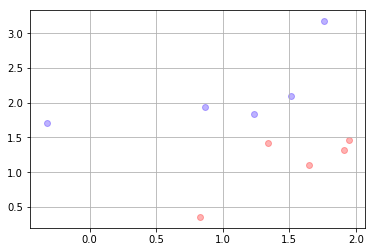

In [5]:
X,y = mc.sample(10)
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
plt.grid()

### Los algoritmos de machine learning:

- Los algoritmos de clasificación **calculan fronteras** entre los datos.
- Parten de una muestra de los datos, **no de las distribuciones**.
- Por tanto, **no conocemos** la forma de la frontera bayesiana.

O sea, **partimos ciegos**!!!!!!!

Para abordar esta situación, **cualquier algoritmo** tiene necesariamente que plantear una alguna suposición de base:

- los datos vienen de distribuciones normales.
- las columnas son estadísticamente independientes.
- la frontera es lineal, o cuadrática.
- la frontera se representa con una red neuronal.

Teniendo esto en cuenta, y **partiendo de una muestra de los datos**:

- el objetivo de un usuario de ML es acercarse lo más posible a la **frontera bayesiana** (que no sabemos cómo es).
- distintos algoritmos ML tienen **distintas capacidades** para modelar fronteras (un clasificador lineal no puede captuarar una frontera cuadrática).
- necesitamos dos tipos de herramientas:
   - una buena colección de algoritmos ML.
   - métodos para saber qué tan cerca estamos de la frontera bayesiana.

### observa cómo un clasificador lineal aproxima la frontera con diferentes tamaños de muestras

- cambia el parámetro `n_samples` y experimenta con el siguiente código.
- usa luego estimadores distintos. P.ej.

        estimator = SVC(gamma=1)
        estimator = RandomForestClassifier()
        estimator = SVC(gamma=100)
        
Hazte las siguientes preguntas:

- ¿qué complejidad es capaz de capturar un estimador?

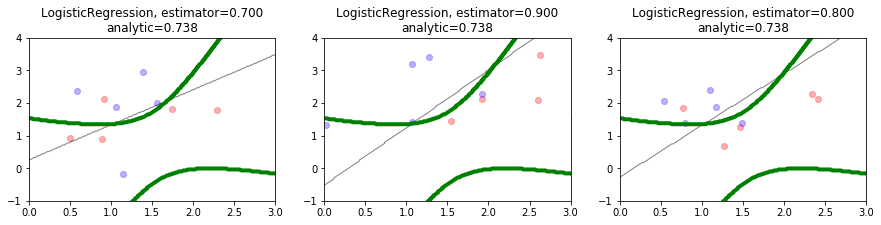

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
reload(mlutils)
n_samples = 10
estimator = LogisticRegression()
plt.figure(figsize=(15,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    mlutils.plot_estimator_border(mc, estimator, mins=[0,-1], maxs=[3,4], n_samples=n_samples, legend=False)

hacemos ahora el experimento más exhaustivo repitiendo 20 veces el siguiente proceso:

- se muestrea el dataset (recuerda que **excepcionalmente** tenemos acceso a las distribuciones que generan los datos y por tanto podemos hacer esto).
- se calcula la fronter de clasificación obtenida por el estimador usando el dataset muestreado.
- se pinta esta frontera (en negro).
- en verde se muestra la **frontera bayesiana**.

100% (4 of 4) |###########################| Elapsed Time: 0:00:01 Time: 0:00:01


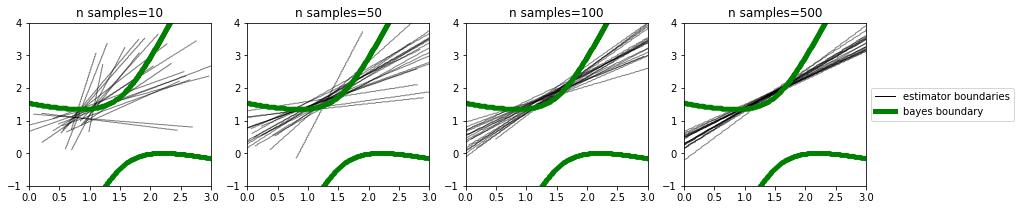

In [7]:
reload(mlutils)
mlutils.sample_borders(mc, estimator, samples = [10,50,100,500], n_reps=20, mins=[0,-1], maxs=[3,4])

## Solo tenemos un dataset

- remuestrea, reentrena para medir el desempeño y entender la estabilidad
- prueba con `test_pct` entre 0.1 y 0.9. observa la divergencia entre train y test cuando `test_pct` es más cercano a 0.9. ¿por qué?
- prueba con `SVC(gamma=100)`. En este caso observa la divergencia entre train y test incluso cuando `test_pct` es pequeño. ¿por qué?
- prubea además con `dataset_size` entre 20 y 500

Entiende la diferencia entre **tener pocos datos** y **overfitting**

Configuraciones interesantes sobre 

    mc = mlutils.Example_Bayes2DClassifier(mean0=[1.5, 1.5], cov0=[[0.5, 0.1], [0.3, 0.5]],
                                            mean1=[1.2, 2.], cov1=[[0.2,0.1],[0,.5]])

- SVC $\gamma=100$, `dataset_size=500` (overfitting con pocos datos, convergencia con muchos)
- SVC $\gamma=100$, `dataset_size=2000` (overfitting con pocos datos, convergencia con muchos)
- SVC $\gamma=.01$, `dataset_size=100` (variabilidad siempre, convergencia promedio con pocos datos)
- SVC $\gamma=1$, `dataset_size=100` (variabilidad siempre, convergencia promedio con pocos datos)
- LinearRegression, `dataset_size=100` (nunca converge a la frontera bayesiana)



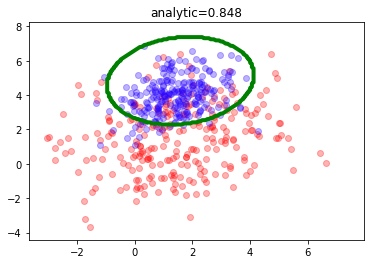

In [8]:
import mlutils
dataset_size = 500
mc = mlutils.Example_Bayes2DClassifier(mean0=[1.5, 1.5], cov0=[[4., 0.5], [0.1, 4.]],
                                        mean1=[1.5,4.], cov1=[[1,0.5],[0.1,1.]])
X,y = mc.sample(dataset_size)
mlutils.plot_estimator_border(mc, n_samples=dataset_size, legend=False)
analitic_score = mc.analytic_score()

In [9]:
test_pct = .5
estimator = SVC(gamma=.01)
#estimator = LogisticRegression()

train_score  0.82
test_score   0.81


Text(0.5,1,u'test accuracy  0.80800')

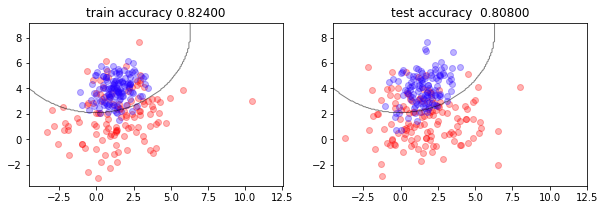

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_pct)
estimator.fit(X_train, y_train)
trsc = estimator.score(X_train, y_train)
tssc = estimator.score(X_test, y_test)
print "train_score %5.2f"%estimator.score(X_train, y_train)
print "test_score  %5.2f"%estimator.score(X_test, y_test)

plt.figure(figsize=(10,3))
plt.subplot(121)
mlutils.plot_2Ddata(X_train, y_train, dots_alpha=.3)
mlutils.plot_2D_boundary(estimator.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=1, line_alpha=.5, label=None)
plt.title("train accuracy %.5f"%estimator.score(X_train, y_train))

plt.subplot(122)
mlutils.plot_2Ddata(X_test, y_test, dots_alpha=.3)
mlutils.plot_2D_boundary(estimator.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=1, line_alpha=.5, label=None)
plt.title("test accuracy  %.5f"%estimator.score(X_test, y_test))

## Multidimensionalidad (>2D)

normalmente tenemos datasets de muchas dimensiones (columnas) y no podemos visualizar los datos como en 2D $\rightarrow$ necesitamos métodos para recabar evidencia sobre si tenemos pocos datos, estamos haciendo overfitting, etc.

Las **curvas de aprendizaje** nos ayudan a esto.

Realiza el experimento desde la sección anterior, con distintos tamaños del dataset inicial y con distintos algoritmos.

100% (9 of 9) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


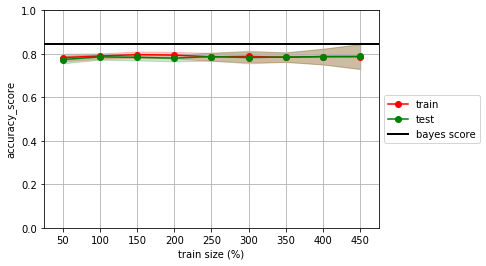

In [11]:
estimator = LogisticRegression()
mlutils.lcurve(estimator, X, y, n_reps=20, score_func=accuracy_score)
plt.axhline(analitic_score, lw=2, color="black", label="bayes score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

100% (9 of 9) |###########################| Elapsed Time: 0:00:02 Time: 0:00:02


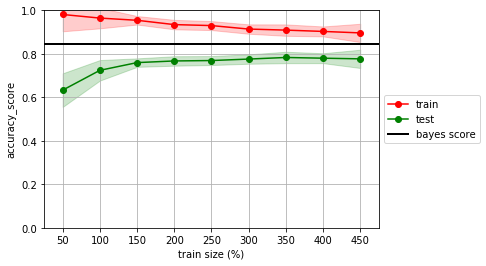

In [12]:
estimator = SVC(gamma=10)
mlutils.lcurve(estimator, X, y, n_reps=20, score_func=accuracy_score)
plt.axhline(analitic_score, lw=2, color="black", label="bayes score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

100% (9 of 9) |###########################| Elapsed Time: 0:00:01 Time: 0:00:01


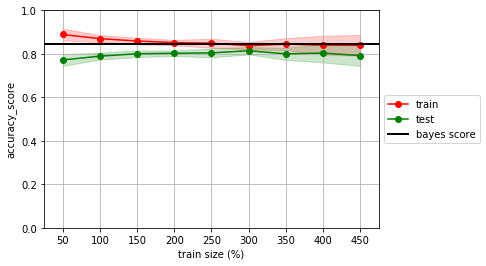

In [13]:
estimator = SVC(gamma=1)
mlutils.lcurve(estimator, X, y, n_reps=20, score_func=accuracy_score)
plt.axhline(analitic_score, lw=2, color="black", label="bayes score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

no olvides que normalmente **no conocemos la _frontera bayesiana_**, y por tanto no tenemos el _bayes score_

## Usamos ahora `sklearn` y `tflow` para construir un estimador lineal 

- usamos todos los datos de un dataset

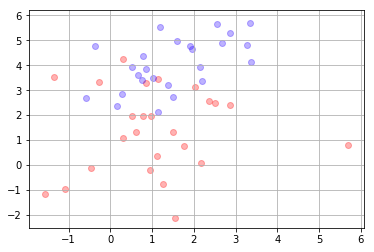

In [14]:
X,y = mc.sample(50)
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
plt.grid()

#### con `sklearn`

accuracy 0.84


(0.560625, 0.439375)

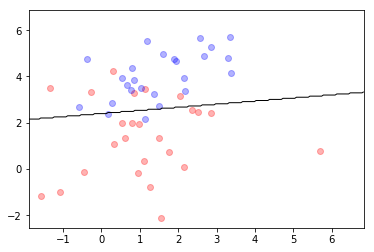

In [15]:
lr = LogisticRegression()
lr.fit(X,y)
print "accuracy", lr.score(X,y)
preds = lr.predict(X)
plt.scatter(X[:,0][y==0], X[:,1][y==0], color="red", alpha=.3)
plt.scatter(X[:,0][y==1], X[:,1][y==1], color="blue", alpha=.3)
mins,maxs = np.min(X,axis=0), np.max(X,axis=0)    
mlutils.plot_2D_boundary(lr.predict, mins, maxs, line_width=1, line_alpha=1, label="estimator boundaries")

#### con `tensorflow` (!!!!!!)

primero hay que construir funciones para la entrada de datos

In [16]:
import tensorflow as tf
print "using tf version", tf.__version__
x0 = tf.feature_column.numeric_column('x0', dtype=tf.float64, shape=())
x1 = tf.feature_column.numeric_column('x1', dtype=tf.float64, shape=()) 

using tf version 1.9.0


In [17]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x = {"x0":X[:,0], "x1":X[:,1]},      # input features
      y = y.astype(int),                   # true labels
      batch_size=1,
      num_epochs=200,               
      shuffle=True)

# Testing
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x = {"x0":X[:,0], "x1":X[:,1]},      # Input features
      y = y.astype(int),
      num_epochs=1,
      shuffle=False)

# Prediction
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
      x = {"x0":X[:,0], "x1":X[:,1]},
      num_epochs=1,
      shuffle=False)

In [18]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x = {"x0":X[:,0], "x1":X[:,1]},      # input features
      y = y.astype(int),                   # true labels
      batch_size=50,
      num_epochs=500,               
      shuffle=True)

entrenamos el estimador

In [19]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x = {"x0":X[:,0], "x1":X[:,1]},      # input features
      y = y.astype(int),                   # true labels
      batch_size=10,
      num_epochs=50,               
      shuffle=True)
!rm -rf output
estimator = tf.estimator.LinearClassifier(feature_columns=[x0,x1], model_dir='./output',
                                          optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01))
estimator.train(input_fn=train_input_fn, steps=None);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4940bbe4d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './output', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./output/model.ckpt.
INFO:tensorflow:loss = 6

obtenemos predicciones y las pintamos

In [20]:
def tflow_predict(tflow_estimator, X_data):
    input_1repeat_fn = tf.estimator.inputs.numpy_input_fn(
          x = {"x0":X_data[:,0], "x1":X_data[:,1]},
          num_epochs=1,
          shuffle=False)  
    
    preds = tflow_estimator.predict(input_fn=input_1repeat_fn)
    preds = [i for i in preds]
    preds = np.r_[[i["class_ids"][0] for i in preds]][:len(X_data)]
    return preds

In [21]:
preds = tflow_predict(estimator, X)
print "prediction accuracy", np.mean(y==preds)
preds

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./output/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
prediction accuracy 0.86


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./output/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


(0.554825, 0.445175)

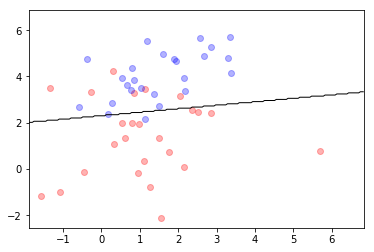

In [22]:
reload(mlutils)
plt.scatter(X[:,0][y==0], X[:,1][y==0], color="red", alpha=.3)
plt.scatter(X[:,0][y==1], X[:,1][y==1], color="blue", alpha=.3)

mins,maxs = np.min(X,axis=0), np.max(X,axis=0)    

pred_fun = lambda X_data: tflow_predict(estimator, X_data)

mlutils.plot_2D_boundary(pred_fun, mins, maxs, line_width=1, line_alpha=1, label="estimator boundaries")

### En este curso veremos porqué `tensorflow` es así, cuándo y cómo usarlo

Probemos ahora con una red neuronal clásica (_multilayer perceptron_).

Experimenta con distintos valores de `hidden_units` y con 10 datos:

- `[2]`: Underfitting
- `[6]`: About right
- `[200]`: Overfitting
- `[3,2]`: Sometimes about right, sometimes different kind of underfitting

pero con 500 datos los resultados son más homogéneos. Comenta la línea de muestreo del dataset para experimentar con distintas configuraciones de `hidden_units` pero con el dataset estable

In [23]:
X,y = mc.sample(100)

estimator = tf.estimator.DNNClassifier(
    feature_columns=[x0,x1],
    hidden_units=[6],
    n_classes=2)

estimator.train(input_fn=train_input_fn, steps=None);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f495f014450>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmp5MbYbS', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp5MbYbS/model.ckpt.
INFO:tensorf

In [24]:
preds = tflow_predict(estimator, X)
print np.mean(y==preds)
preds

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5MbYbS/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.85


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5MbYbS/model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


(0.6448, 0.3552)

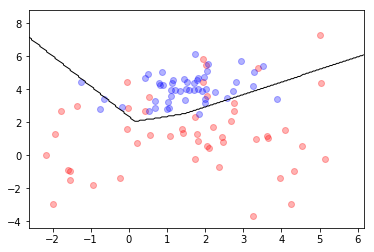

In [25]:
reload(mlutils)
plt.scatter(X[:,0][y==0], X[:,1][y==0], color="red", alpha=.3)
plt.scatter(X[:,0][y==1], X[:,1][y==1], color="blue", alpha=.3)

mins,maxs = np.min(X,axis=0), np.max(X,axis=0)    
pred_fun = lambda X_data: tflow_predict(estimator, X_data)
mlutils.plot_2D_boundary(pred_fun, mins, maxs, line_width=1, line_alpha=1, label="estimator boundaries")